In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def combine_mom6_restarts(file_name):
    datasets = []
    for nrange in [range(0,4), range(4,8), range(8,12), range(12,16)]:
        flist = ['%s.%04i' %(file_name, n) for n in nrange]
        print(flist)
        datasets_sub = [xr.open_mfdataset(file) for file in flist]
        ds_sub = xr.merge(datasets_sub)
        print('###########debug###########')
        print(ds_sub)
        print('###########debug###########')
#         ds_test = xr.open_mfdataset([os.path.join(path, file) for file in flist])
        
        datasets.append(ds_sub)
#     out = xr.concat(datasets, dim=concat_dim) 
    out = xr.merge(datasets) # not sure why I have to do these seperately to work...
    #This does concat existing dimensions, which is I guess what I want, but it would be nice if there would
    out.attrs['jb_notes'] = 'Combined using xarray by Julius Busecke. See https://github.com/jbusecke/mom6_design for details'
    return out

def combine_mom6_icebergs(file_name):
    datasets = []
    for nrange in [range(0,4), range(4,8), range(8,12), range(12,16)]:
        flist = ['%s.%04i' %(file_name, n) for n in nrange]
        print(flist)
        datasets_sub = [xr.open_mfdataset(file) for file in flist]
        ds_sub = xr.merge(datasets_sub)
        print('###########debug###########')
        print(ds_sub)
        print('###########debug###########')
#         ds_test = xr.open_mfdataset([os.path.join(path, file) for file in flist])
        
        datasets.append(ds_sub)
#     out = xr.concat(datasets, dim=concat_dim) 
    out = xr.merge(datasets) # not sure why I have to do these seperately to work...
    #This does concat existing dimensions, which is I guess what I want, but it would be nice if there would
    out.attrs['jb_notes'] = 'Combined using xarray by Julius Busecke. See https://github.com/jbusecke/mom6_design for details'
    return out

In [3]:
path = '/archive/Julius.Busecke/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/archive/restart/20020101'
path_iceberg = '/archive/Julius.Busecke/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/archive_alternative_with_icebergs/hide_from_fre/'
odir = '/archive/Julius.Busecke/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/archive/restart_combined_experimental/new/'

In [4]:
# The icebergs are all empty?...

In [8]:
ds_icebergs = xr.open_mfdataset('/archive/Julius.Busecke/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/archive_alternative_with_icebergs/hide_from_fre/icebergs.res.nc.*', drop_variables='i')
print(ds_icebergs)

<xarray.Dataset>
Dimensions:       (i: 0)
Dimensions without coordinates: i
Data variables:
    lon           (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    lat           (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    uvel          (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    vvel          (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    mass          (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    ine           (i) int32 dask.array<shape=(0,), chunksize=(0,)>
    jne           (i) int32 dask.array<shape=(0,), chunksize=(0,)>
    thickness     (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    width         (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    length        (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    start_lon     (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    start_lat     (i) float64 dask.array<shape=(0,), chunksize=(0,)>
    start_year    (i) int32 dask.array<shape=(0,), chunksize=(0,)>
    id_cnt       

In [11]:
# just rename the first file...since they are all empty anyways...
file = '/archive/Julius.Busecke/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/archive_alternative_with_icebergs/hide_from_fre/icebergs.res.nc.0000'
!cp {file} {odir}/icebergs.res.nc

In [4]:
# ice model restarts
ds_icemodel = combine_mom6_restarts(path, 'ice_model.res.nc')
print(ds_icemodel.nbytes/1e9, ds_icemodel)
ds_icemodel.to_netcdf(os.path.join(odir, 'ice_model.res.nc'))

# # # calving restart
ds_calving = combine_mom6_restarts(path, 'calving.res.nc')
print(ds_calving.nbytes/1e9, ds_calving)
ds_calving.to_netcdf(os.path.join(odir,'calving.res.nc'))

###########debug###########
<xarray.Dataset>
Dimensions:          (Time: 1, aaxis_1: 1, aaxis_2: 4, xaxis_1: 2880, yaxis_1: 560, zaxis_1: 6, zaxis_2: 5)
Coordinates:
  * xaxis_1          (xaxis_1) float64 1.0 2.0 3.0 ... 2.879e+03 2.88e+03
  * yaxis_1          (yaxis_1) float64 1.0 2.0 3.0 4.0 ... 558.0 559.0 560.0
  * zaxis_1          (zaxis_1) float64 1.0 2.0 3.0 4.0 5.0 6.0
  * zaxis_2          (zaxis_2) float64 1.0 2.0 3.0 4.0 5.0
  * aaxis_1          (aaxis_1) float64 1.0
  * aaxis_2          (aaxis_2) float64 1.0 2.0 3.0 4.0
  * Time             (Time) float64 1.0
Data variables:
    flux_u           (Time, yaxis_1, xaxis_1) float64 dask.array<shape=(1, 560, 2880), chunksize=(1, 560, 2880)>
    flux_v           (Time, yaxis_1, xaxis_1) float64 dask.array<shape=(1, 560, 2880), chunksize=(1, 560, 2880)>
    flux_t           (Time, yaxis_1, xaxis_1) float64 dask.array<shape=(1, 560, 2880), chunksize=(1, 560, 2880)>
    flux_q           (Time, yaxis_1, xaxis_1) float64 dask.array<sha

In [ ]:
# MOM restarts (these need a slight bit more TLC)
for filename in ['MOM.res.nc']+['MOM.res_%i.nc' %i for i in range(1,17)]:
# for filename in ['MOM.res_%i.nc' %i for i in range(10,17)]: # fix only the ones that failed

    print(filename)
    ds_mom = combine_mom6_restarts(path, filename)
    print(ds_mom)
    
    #this allows datasets with different x dimensions to be logically merged? 
    print('Filesize: %s GB' %str(ds_mom.nbytes/1e9))
    if ds_mom.nbytes/1e9 > 5.0:
        print('Something is kaput')
        break
        
    print('Writing File')
    ds_mom.to_netcdf(os.path.join(odir, filename))
    del ds_mom

MOM.res.nc
###########debug###########
<xarray.Dataset>
Dimensions:  (Layer: 75, Time: 1, lath: 560, lonh: 2880)
Coordinates:
  * lonh     (lonh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * lath     (lath) float64 -83.62 -83.58 -83.54 -83.5 ... -55.07 -55.0 -54.92
  * Layer    (Layer) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
  * Time     (Time) timedelta64[ns] 90353 days 01:16:18.871345
Data variables:
    Temp     (Time, Layer, lath, lonh) float64 dask.array<shape=(1, 75, 560, 2880), chunksize=(1, 75, 560, 2880)>
###########debug###########
###########debug###########
<xarray.Dataset>
Dimensions:  (Layer: 75, Time: 1, lath: 560, lonh: 2880)
Coordinates:
  * lonh     (lonh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * lath     (lath) float64 -54.85 -54.78 -54.71 -54.64 ... 3.747 3.872 3.997
  * Layer    (Layer) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
  * Time     (Time) timedelta64[ns] 90353 days 01:16:18.871345
Data

Lets see if those restarts work right out of the box with my discover setup... otherwise use [FRE-nctools](https://github.com/NOAA-GFDL/FRE-NCtools) as suggeste [here](https://github.com/NOAA-GFDL/MOM6/issues/958).

## QC the output files
I am having trouble in particular with the ice...model crashed due to icebergs being born on land.
This is due to very high values on land!


In [26]:
ds_check_calving = xr.open_mfdataset(os.path.join(odir,'calving.res.nc'))
ds_check_calving

<xarray.Dataset>
Dimensions:              (Time: 1, xaxis_1: 2880, yaxis_1: 2240, zaxis_1: 10)
Coordinates:
  * yaxis_1              (yaxis_1) float64 1.0 2.0 3.0 ... 2.239e+03 2.24e+03
  * xaxis_1              (xaxis_1) float64 1.0 2.0 3.0 ... 2.879e+03 2.88e+03
  * zaxis_1              (zaxis_1) float64 1.0 2.0 3.0 4.0 ... 7.0 8.0 9.0 10.0
  * Time                 (Time) float64 1.0
Data variables:
    stored_ice           (Time, zaxis_1, yaxis_1, xaxis_1) float64 dask.array<shape=(1, 10, 2240, 2880), chunksize=(1, 10, 2240, 2880)>
    stored_heat          (Time, yaxis_1, xaxis_1) float64 dask.array<shape=(1, 2240, 2880), chunksize=(1, 2240, 2880)>
    iceberg_counter_grd  (Time, yaxis_1, xaxis_1) float64 dask.array<shape=(1, 2240, 2880), chunksize=(1, 2240, 2880)>
Attributes:
    jb_notes:  Combined using xarray by Julius Busecke. See https://github.co...

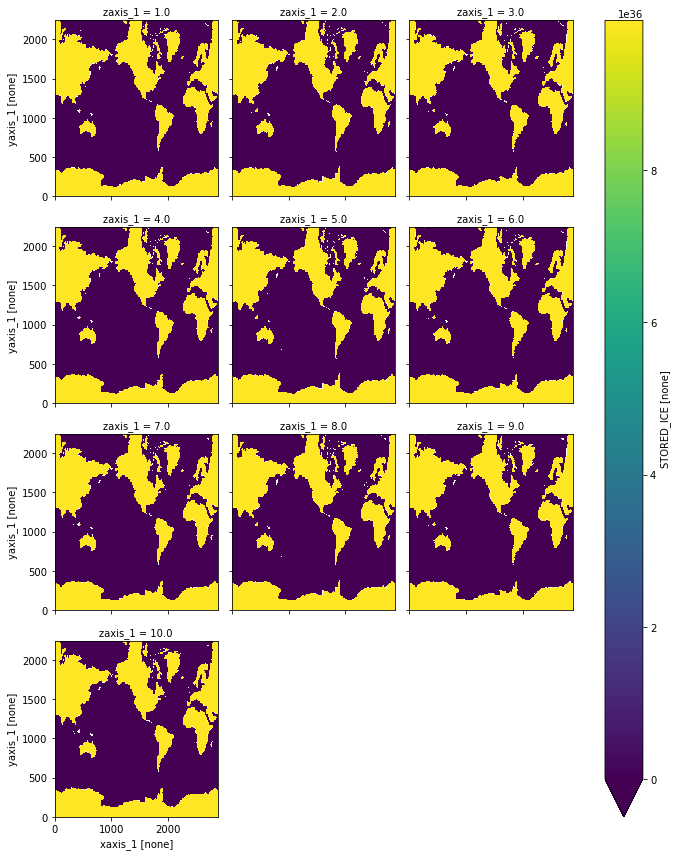

In [11]:
ds_check_calving.stored_ice.where(ds_check_calving.stored_ice>0).plot(col='zaxis_1', col_wrap=3, robust=True)

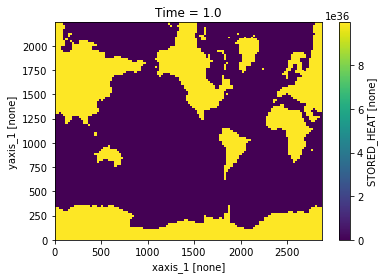

In [15]:
ds_check_calving.stored_heat.plot(robust=True)

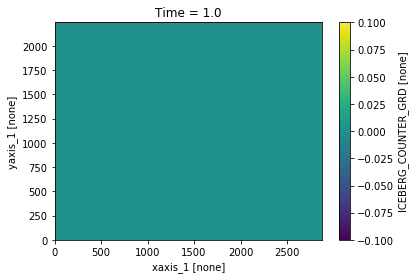

In [14]:
ds_check_calving.iceberg_counter_grd.plot(robust=True)

In [25]:
ds_check_icemodel = xr.open_mfdataset(os.path.join(odir,'ice_model.res.nc'))
# ds_check_icemodel

In [15]:
ds_check_icemodel.calving.max().load()#.plot()

<xarray.DataArray 'calving' ()>
array(9.96921e+36)

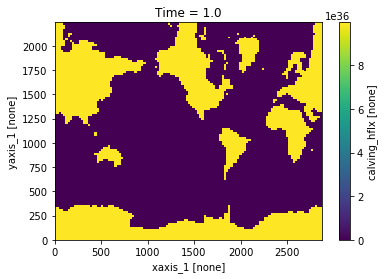

In [20]:
ds_check_icemodel.calving_hflx.plot()

# mask out all necessary files

<xarray.Dataset>
Dimensions:  (nx: 2880, ny: 2240)
Dimensions without coordinates: nx, ny
Data variables:
    mask     (ny, nx) float64 ...
Attributes:
    grid_version:  0.2
    code_version:  $Name:  $
    history:       /net2/nnz/FRE-NCtools/build.fre-nctools.gfdl-ws.all.DESy0/...


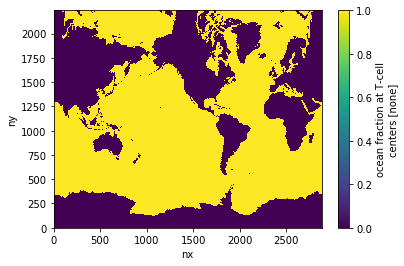

In [28]:
# load ocean mask...
griddir = '/archive/Julius.Busecke/model_setups/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle4/input_files/grid/untarred/'
mask = xr.open_dataset(os.path.join(griddir, 'ocean_mask.nc'))
print(mask)
mask.mask.plot()

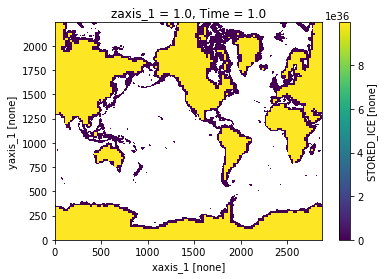

In [32]:
# convert dimensions of mask to calving file
mask_ocean = mask.mask.rename({'nx':'xaxis_1', 'ny':'yaxis_1'})
ds_check_calving.stored_ice.isel(zaxis_1=0).where(mask_ocean==0).plot()

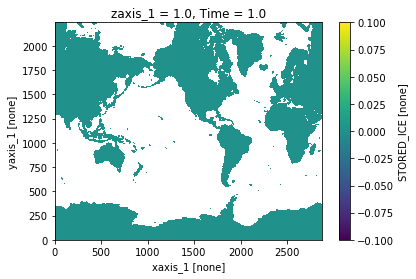

In [33]:
ds_calving_padded = ds_check_calving.where(mask_ocean).fillna(0)
ds_calving_padded.stored_ice.isel(zaxis_1=0).where(mask_ocean==0).plot()

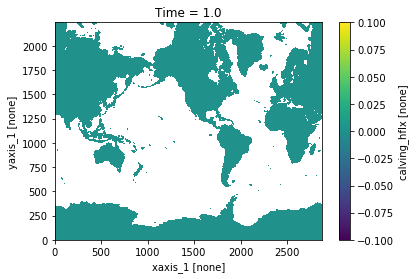

In [37]:
ds_icemodel_padded = ds_check_icemodel.where(mask_ocean).fillna(0)
ds_icemodel_padded.calving_hflx.where(mask_ocean==0).plot()

In [38]:
ds_icemodel_padded.to_netcdf(os.path.join(odir, 'ice_model.res.nc.padded'))

In [40]:
ds_calving_padded.to_netcdf(os.path.join(odir, 'calving.res.nc.padded'))